# Importing Libraries

In [14]:
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
import matplotlib.pyplot as plt
import spacy
nlp= spacy.load('en')
from gensim.models.phrases import Phrases, Phraser
from spacy.pipeline import Pipe
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)
#from sense2vec import Sense2VecComponent
#s2v = Sense2VecComponent('/path/to/reddit_vectors-1.1.0')
#nlp.add_pipe(s2v)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nitin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Importing csv data File

In [15]:
"""USING Kaggle Dataset for training the model
https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe
"""
df = pd.read_csv("C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/Hotel_Reviews.csv")
#C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/df_Hotel_Reviews.csv

In [16]:
df.count()

Hotel_Address                                 515738
Additional_Number_of_Scoring                  515738
Review_Date                                   515738
Average_Score                                 515738
Hotel_Name                                    515738
Reviewer_Nationality                          515738
Negative_Review                               515738
Review_Total_Negative_Word_Counts             515738
Total_Number_of_Reviews                       515738
Positive_Review                               515738
Review_Total_Positive_Word_Counts             515738
Total_Number_of_Reviews_Reviewer_Has_Given    515738
Reviewer_Score                                515738
Tags                                          515738
days_since_review                             515738
lat                                           512470
lng                                           512470
dtype: int64

# Divide data into 2 parts - Lower and upper as per rating

In [17]:
train_df_lower = df.drop(df[df.Reviewer_Score > 6].index)

In [18]:
train_df_upper = df.drop(df[df.Reviewer_Score < 6].index)

# Since the data is skewed towards 10, take a fraction of 'Review_Score' upper dataframe

In [19]:
train_df_upper_fraction = train_df_upper.sample(frac = 0.2, random_state = 100)

# Merge and form new DF

In [20]:
frames = (train_df_lower, train_df_upper_fraction)
train_df = pd.concat(frames)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145406 entries, 0 to 304047
Data columns (total 17 columns):
Hotel_Address                                 145406 non-null object
Additional_Number_of_Scoring                  145406 non-null int64
Review_Date                                   145406 non-null object
Average_Score                                 145406 non-null float64
Hotel_Name                                    145406 non-null object
Reviewer_Nationality                          145406 non-null object
Negative_Review                               145406 non-null object
Review_Total_Negative_Word_Counts             145406 non-null int64
Total_Number_of_Reviews                       145406 non-null int64
Positive_Review                               145406 non-null object
Review_Total_Positive_Word_Counts             145406 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    145406 non-null int64
Reviewer_Score                                145406 non-null flo

In [22]:
train = train_df[['Negative_Review', 'Positive_Review', 'Reviewer_Score']]

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145406 entries, 0 to 304047
Data columns (total 3 columns):
Negative_Review    145406 non-null object
Positive_Review    145406 non-null object
Reviewer_Score     145406 non-null float64
dtypes: float64(1), object(2)
memory usage: 4.4+ MB


In [24]:
hotel_review = train.to_csv("C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/df_Hotel_Reviews_undersample.csv")

# Lowercase Words

In [25]:
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer
stop = stopwords.words('english')
alpha_tokenizer = RegexpTokenizer('[A-Za-z]\w+')
from nltk.stem.wordnet import WordNetLemmatizer
lemmer = WordNetLemmatizer()

In [13]:
"""https://www.kaggle.com/defeater/importance-of-a-linguistic-pre-processing"""
def process_sent(words, lemmatize=False, stem=False):
    words = words.lower()
    tokens = alpha_tokenizer.tokenize(words)
    for index, word in enumerate(tokens):
        if lemmatize:
            tokens[index] = lemmer.lemmatize(word)
        elif stem:
            tokens[index] = stemmer.stem(word)
        else:
            tokens[index] = word
    return tokens

In [30]:
corpus_positive = [process_sent(sent, lemmatize=True, stem=False) for sent in positive]

In [ ]:
corpus_negative = [process_sent(sent, lemmatize=True, stem=False) for sent in negative]

In [26]:
train = train.apply(lambda x: x.astype(str).str.lower())

In [27]:
train.head()

,Negative_Review,Positive_Review,Reviewer_Score
0,i am so angry that i made this post available...,only the park outside of the hotel was beauti...,2.9
3,my room was dirty and i was afraid to walk ba...,great location in nice surroundings the bar a...,3.8
6,cleaner did not change our sheet and duvet ev...,the room is spacious and bright the hotel is ...,4.6
11,6 30 am started big noise workers loading woo...,style location rooms,5.8
12,the floor in my room was filfy dirty very bas...,comfy bed good location,4.6


In [28]:
train['Reviewer_Score'] = round(train['Reviewer_Score'].astype(float))

In [29]:
train.head()

,Negative_Review,Positive_Review,Reviewer_Score
0,i am so angry that i made this post available...,only the park outside of the hotel was beauti...,3.0
3,my room was dirty and i was afraid to walk ba...,great location in nice surroundings the bar a...,4.0
6,cleaner did not change our sheet and duvet ev...,the room is spacious and bright the hotel is ...,5.0
11,6 30 am started big noise workers loading woo...,style location rooms,6.0
12,the floor in my room was filfy dirty very bas...,comfy bed good location,5.0


count    145406.000000
mean          7.391476
std           2.267350
min           2.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          10.000000
Name: Reviewer_Score, dtype: float64


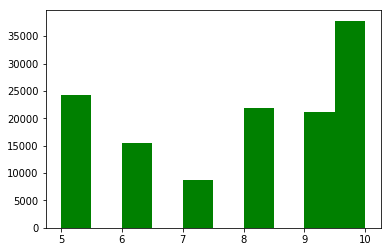

In [30]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
print(train.Reviewer_Score.describe())
plt.hist( train.Reviewer_Score, range=[5, 10], facecolor='green')#, align='mid')
plt.show()

In [31]:
%%time
negative = train['Negative_Review'].str.replace('[^\w\s]',' ')
positive = train['Positive_Review'].str.replace('[^\w\s]',' ')

Wall time: 1.23 s


In [32]:
train.head()

,Negative_Review,Positive_Review,Reviewer_Score
0,i am so angry that i made this post available...,only the park outside of the hotel was beauti...,3.0
3,my room was dirty and i was afraid to walk ba...,great location in nice surroundings the bar a...,4.0
6,cleaner did not change our sheet and duvet ev...,the room is spacious and bright the hotel is ...,5.0
11,6 30 am started big noise workers loading woo...,style location rooms,6.0
12,the floor in my room was filfy dirty very bas...,comfy bed good location,5.0


In [33]:
#print (negative[0])
print (negative[0])

 i am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place i made my booking via booking com we stayed for 6 nights in this hotel from 11 to 17 july upon arrival we were placed in a small room on the 2nd floor of the hotel it turned out that this was not the room we booked i had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings the room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it i intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day so i had to check out the next day before 11 o clock in order to get the room i waned to not the best way to begin yo

In [35]:
from spacy.lang.en.stop_words import STOP_WORDS
stop = set(STOP_WORDS)
#print(STOP_WORDS)

In [36]:
negative = negative.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [37]:
positive = positive.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [38]:
def process_sent(words, lemmatize=False, stem=False):
    words = words.lower()
    tokens = alpha_tokenizer.tokenize(words)
    for index, word in enumerate(tokens):
        if lemmatize:
            tokens[index] = lemmer.lemmatize(word)
        elif stem:
            tokens[index] = stemmer.stem(word)
        else:
            tokens[index] = word
    return tokens

In [39]:
corpus_positive = [process_sent(sent, lemmatize=True, stem=False) for sent in positive]

In [40]:
corpus_negative = [process_sent(sent, lemmatize=True, stem=False) for sent in negative]

In [41]:
type(corpus_negative)

list

In [43]:
corpus_negative[0]

['angry',
 'post',
 'available',
 'possible',
 'site',
 'use',
 'planing',
 'trip',
 'mistake',
 'booking',
 'place',
 'booking',
 'booking',
 'com',
 'stayed',
 'night',
 'hotel',
 'july',
 'arrival',
 'placed',
 'small',
 'room',
 'nd',
 'floor',
 'hotel',
 'turned',
 'room',
 'booked',
 'specially',
 'reserved',
 'level',
 'duplex',
 'room',
 'big',
 'window',
 'high',
 'ceiling',
 'room',
 'ok',
 'don',
 'mind',
 'broken',
 'window',
 'closed',
 'hello',
 'rain',
 'mini',
 'fridge',
 'contained',
 'sort',
 'bio',
 'weapon',
 'guessed',
 'smell',
 'intimately',
 'asked',
 'change',
 'room',
 'explaining',
 'time',
 'booked',
 'duplex',
 'btw',
 'cost',
 'simple',
 'double',
 'got',
 'way',
 'volume',
 'high',
 'ceiling',
 'offered',
 'room',
 'day',
 'check',
 'day',
 'clock',
 'order',
 'room',
 'waned',
 'best',
 'way',
 'begin',
 'holiday',
 'wait',
 'till',
 'order',
 'check',
 'new',
 'room',
 'wonderful',
 'waist',
 'time',
 'room',
 'got',
 'wanted',
 'peaceful',
 'internal',

In [24]:
#Removing stop words
stop = set(STOP_WORDS)
#adding stopwords
negative = negative.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [25]:
positive = positive.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [25]:
negative = negative.apply(nltk.word_tokenize)
positive = positive.apply(nltk.word_tokenize)
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
positive

In [26]:
score = train['Reviewer_Score'].astype(int)

In [27]:
data = pd.read_csv("C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/df_Hotel_Reviews_undersample_notags.csv")#, sep=',',header=None))

0                       park outside of hotel beautiful
3     great location nice surroundings bar restauran...
6     room spacious bright hotel located quiet beaut...
11                                 style location rooms
12                              comfy bed good location
Name: Positive_Review, dtype: object

In [ ]:
"""
https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

%%time
from nltk.corpus import stopwords
import nltk, re, string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import numpy as np
from sklearn.preprocessing import normalize
from spacy.lang.en.stop_words import STOP_WORDS
stop = set(STOP_WORDS)



docs=data['Positive_Review']
#docs=data['Negative_Review']
#target=data[3]

def get_doc_tokens(doc,lem):
        #stop_words = stop
        tokens=[token.strip()
                for token in nltk.word_tokenize(doc.lower())
                if token.strip() not in stop and
                token.strip() not in string.punctuation]
        
        tagged_tokens= nltk.pos_tag(tokens)
        
        def get_wordnet_pos(pos_tag):
    
            if pos_tag.startswith('J'):
                return wordnet.ADJ

            elif pos_tag.startswith('V'):
                return wordnet.VERB

            elif pos_tag.startswith('N'):
                return wordnet.NOUN

            elif pos_tag.startswith('R'):
                return wordnet.ADV
            else:
                return wordnet.NOUN
        
        wordnet_lemmatizer = WordNetLemmatizer()
        if lem == True:
            negative_lemma=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag))      
            for (word, tag) in tagged_tokens \
            if word not in stop and \
            word not in string.punctuation]
        else:
            negative_lemma = tokens

        return negative_lemma


docs_tokens=[get_doc_tokens(doc,True) for doc in docs] 
"""

In [ ]:
#docs_tokens.to_csv("C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/positive_lemma.csv")

import csv
#with open('C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/positive_lemma.csv', 'wb') as output:
with open("C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/positive_lemma1.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in docs_tokens:
        writer.writerow([val])  

In [ ]:
positive = pd.read_csv("C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/positive_lemma1.csv")#, sep=',',header=None))

In [ ]:
negative = pd.read_csv("C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/negative_lemma.csv")#, sep=',',header=None))

# Calculate Negative Sentiments

In [46]:
sid = SentimentIntensityAnalyzer()
comments = []
list_negative=[]
for i in negative:
    comments.append(i)
                                        #print("Sentiment Analysis for " + filename + ":")
for comment in comments:
                                            #         print(comment)
    ss = sid.polarity_scores(comment)
                                                #print(type(ss))
    #for k in sorted(ss):                                                   #print('{0}: {1}, '.format(k, ss[k]))
    list_negative.append(ss)

In [47]:
print(negative[101])
list_negative[101]

hotel having construction work live tables general cleanliness restaurant 4 star surfaces sticky old food room narrow steep staircase bed difficult come thought


{'compound': -0.4767, 'neg': 0.508, 'neu': 0.492, 'pos': 0.0}

# Calculate Positive Sentiments

In [48]:
comments = []
list_positive=[]
for i in positive:
    comments.append(i)
                                        #print("Sentiment Analysis for " + filename + ":")
for comment in comments:
    #print(comment)
    ss = sid.polarity_scores(comment)
                                                #print(type(ss))
    #for k in sorted(ss):                                                   #print('{0}: {1}, '.format(k, ss[k]))
    list_positive.append(ss)

In [31]:
positive.head()
"""
https://www.kaggle.com/defeater/importance-of-a-linguistic-pre-processing
"""

def process_sent(words, lemmatize=False, stem=False):
    words = words.lower()
    tokens = alpha_tokenizer.tokenize(words)
    for index, word in enumerate(tokens):
        if lemmatize:
            tokens[index] = lemmer.lemmatize(word)
        elif stem:
            tokens[index] = stemmer.stem(word)
        else:
            tokens[index] = word
    return tokens

corpus_lemmatized = [process_sent(sent, lemmatize=True, stem=False) for sent in positive]

0                       park outside of hotel beautiful
3     great location nice surroundings bar restauran...
6     room spacious bright hotel located quiet beaut...
11                                 style location rooms
12                              comfy bed good location
Name: Positive_Review, dtype: object

In [62]:
len(list_positive)

145406

In [50]:
j = 0
tmp = pd.DataFrame(list_negative[0], index=[0])
for i in range(3,len(list_negative)):
    if i%4 == 0:p
        j += 1
        tmp = pd.concat([tmp,pd.DataFrame(list_negative[i],index = [j])])

In [51]:
j = 0
tmp_p = pd.DataFrame(list_positive[0], index=[0])
for i in range(3,len(list_positive)):
    if i%4 == 0:
        j += 1
        tmp_p = pd.concat([tmp_p,pd.DataFrame(list_positive[i],index = [j])])

In [52]:
positive.reset_index (drop=True, inplace=True)
negative.reset_index (drop=True, inplace=True)

In [57]:

df_negative =pd.concat([negative,tmp],axis=1)
df_negative.tail()

,Negative_Review,compound,neg,neu,pos
145401,small comfortable bathroom,NaN,NaN,NaN,NaN
145402,works time stayed,NaN,NaN,NaN,NaN
145403,checking people reception desk computers ackno...,NaN,NaN,NaN,NaN
145404,negative,NaN,NaN,NaN,NaN
145405,bar hotel,NaN,NaN,NaN,NaN


In [54]:
df_negative.to_csv("C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/negative_sentiment.csv")

In [55]:
df_positive =pd.concat([positive,tmp_p],axis=1)
df_positive.head()

,Positive_Review,compound,neg,neu,pos
0,park outside hotel beautiful,0.5994,0.000,0.435,0.565
1,great location nice surroundings bar restauran...,0.4404,0.000,0.508,0.492
2,room spacious bright hotel located quiet beaut...,0.6369,0.000,0.588,0.412
3,style location rooms,0.5994,0.000,0.204,0.796
4,comfy bed good location,0.6249,0.124,0.547,0.328


In [56]:
df_positive.to_csv("C:/Users/Nitin/Desktop/Desktop FOlder/Study Material/Semester 2/BIA 660/Project work/515k-hotel-reviews-data-in-europe/positive_sentiment.csv")